In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colors

from plyfile import PlyData, PlyElement

from sklearn.model_selection import KFold

import lightgbm as lgb

In [2]:
def read_ply(file_name):
    
    plydata = PlyData.read(file_name)
    
    num_features = len(plydata.elements[0].properties)
    name_features = [plydata.elements[0].properties[i].name for i in range(num_features)]
    
    df = pd.DataFrame(columns = name_features)
    for name in name_features:
        df[name] = plydata.elements[0].data[name]
        
    return df

In [3]:
def plot_histogram(x, title = 'Hist'):
    
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title)

    # N is the count in each bin, bins is the lower-limit of the bin
    N, bins, patches = axs.hist(x, bins = 7, align = 'mid', rwidth = 0.5)

    # We'll color code by height, but you could use any scalar
    fracs = N / N.max()

    # we need to normalize the data to 0..1 for the full range of the colormap
    norm = colors.Normalize(fracs.min(), fracs.max())

    # Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
        
    plt.grid()
    plt.show()

In [4]:
dict_labels = { 0: 'unclassified',
                1: 'ground',
                2: 'buildings',
                3: 'poles',
                4: 'pedestrians',
                5: 'cars',
                6: 'vegetation'}

In [5]:
df_lille_1 = read_ply('../Benchmark_MVA/training/MiniLille1_fd.ply')

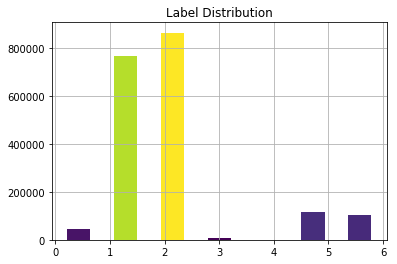

In [6]:
plot_histogram(df_lille_1['class'], "Label Distribution")

In [17]:
df_lille_2 = read_ply('../Benchmark_MVA/training/MiniLille2_fd.ply')

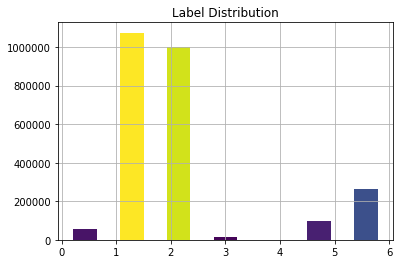

In [18]:
plot_histogram(df_lille_2['class'], "Label Distribution")

In [19]:
df_paris_1 = read_ply('../Benchmark_MVA/training/MiniParis1_fd.ply')

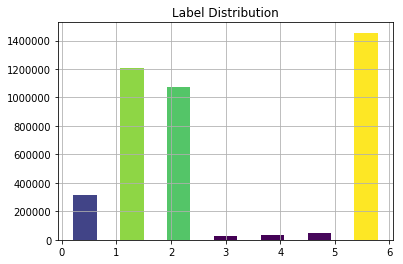

In [20]:
plot_histogram(df_paris_1['class'], "Label Distribution")

In [21]:
df = pd.concat([df_lille_1, df_lille_2, df_paris_1]).reset_index(drop = True)

In [22]:
df.to_csv("all_data.csv", index = False, header = True)

In [5]:
df = pd.read_csv("all_data.csv")

In [6]:
df = df[df['class'] != 0]

In [7]:
np.unique(df["class"], return_counts = True)

(array([1, 2, 3, 4, 5, 6]),
 array([3052023, 2937473,   43413,  136578,  260837, 1716521]))

# Data Split

In [11]:
X = df.iloc[:, 4:].values
Y = df.iloc[:, 3].values - 1

In [10]:
kf = KFold(n_splits = 2)

In [11]:
kf.get_n_splits(X)

2

In [14]:
for train_index, test_index in kf.split(X):
    
    lgb_train = lgb.Dataset(X[train_index], Y[train_index])
    lgb_eval = lgb.Dataset(X[test_index], Y[test_index], reference = lgb_train)
    
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': ['multi_error', 'multi_logloss'],
        'num_class': 7,
        'num_leaves': 25,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }
    
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round = 200,
                    valid_sets = lgb_eval,
                    early_stopping_rounds = 5)
    
    y_hat = gbm.predict(X[test_index])
    print((y_hat.argmax(1) == Y[test_index]).sum() / len(Y[test_index]))

[1]	valid_0's multi_logloss: 1.48639	valid_0's multi_error: 0.94852
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.41413	valid_0's multi_error: 0.546863
[3]	valid_0's multi_logloss: 1.35177	valid_0's multi_error: 0.330933
[4]	valid_0's multi_logloss: 1.29563	valid_0's multi_error: 0.268306
[5]	valid_0's multi_logloss: 1.24436	valid_0's multi_error: 0.229489
[6]	valid_0's multi_logloss: 1.19802	valid_0's multi_error: 0.214848
[7]	valid_0's multi_logloss: 1.15541	valid_0's multi_error: 0.204775
[8]	valid_0's multi_logloss: 1.11648	valid_0's multi_error: 0.198323
[9]	valid_0's multi_logloss: 1.081	valid_0's multi_error: 0.190417
[10]	valid_0's multi_logloss: 1.04777	valid_0's multi_error: 0.185328
[11]	valid_0's multi_logloss: 1.01608	valid_0's multi_error: 0.180877
[12]	valid_0's multi_logloss: 0.986676	valid_0's multi_error: 0.17779
[13]	valid_0's multi_logloss: 0.959648	valid_0's multi_error: 0.174249
[14]	valid_0's multi_logloss: 0.933992	v

KeyboardInterrupt: 

In [12]:
split = round(len(X) * 0.05)
X_val, Y_val = X[:split], Y[:split]
X_train, Y_train = X[split:], Y[split:]

lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_val, Y_val, reference = lgb_train)
    
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': ['multi_error', 'multi_logloss'],
    'num_class': 6,
    'num_leaves': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
    
gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 300,
                valid_sets = lgb_eval,
                early_stopping_rounds = 200)
    
y_hat = gbm.predict(X_val)
print((y_hat.argmax(1) == Y_val).sum() / len(Y_val))

[1]	valid_0's multi_logloss: 1.2892	valid_0's multi_error: 0.159296
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's multi_logloss: 1.22179	valid_0's multi_error: 0.141228
[3]	valid_0's multi_logloss: 1.16063	valid_0's multi_error: 0.139502
[4]	valid_0's multi_logloss: 1.1071	valid_0's multi_error: 0.136487
[5]	valid_0's multi_logloss: 1.05889	valid_0's multi_error: 0.136173
[6]	valid_0's multi_logloss: 1.01455	valid_0's multi_error: 0.137273
[7]	valid_0's multi_logloss: 0.974371	valid_0's multi_error: 0.137808
[8]	valid_0's multi_logloss: 0.93648	valid_0's multi_error: 0.138559
[9]	valid_0's multi_logloss: 0.900548	valid_0's multi_error: 0.137869
[10]	valid_0's multi_logloss: 0.868102	valid_0's multi_error: 0.13769
[11]	valid_0's multi_logloss: 0.837522	valid_0's multi_error: 0.136222
[12]	valid_0's multi_logloss: 0.809528	valid_0's multi_error: 0.133988
[13]	valid_0's multi_logloss: 0.782359	valid_0's multi_error: 0.13006
[14]	valid_0's multi_logloss: 0.75

[115]	valid_0's multi_logloss: 0.249382	valid_0's multi_error: 0.0873615
[116]	valid_0's multi_logloss: 0.248666	valid_0's multi_error: 0.0872829
[117]	valid_0's multi_logloss: 0.247641	valid_0's multi_error: 0.0870399
[118]	valid_0's multi_logloss: 0.247089	valid_0's multi_error: 0.0869417
[119]	valid_0's multi_logloss: 0.246466	valid_0's multi_error: 0.0868852
[120]	valid_0's multi_logloss: 0.245837	valid_0's multi_error: 0.0867158
[121]	valid_0's multi_logloss: 0.245144	valid_0's multi_error: 0.0865906
[122]	valid_0's multi_logloss: 0.244574	valid_0's multi_error: 0.0865121
[123]	valid_0's multi_logloss: 0.243878	valid_0's multi_error: 0.0863893
[124]	valid_0's multi_logloss: 0.243207	valid_0's multi_error: 0.0862592
[125]	valid_0's multi_logloss: 0.242545	valid_0's multi_error: 0.0861316
[126]	valid_0's multi_logloss: 0.241904	valid_0's multi_error: 0.0859892
[127]	valid_0's multi_logloss: 0.241266	valid_0's multi_error: 0.0858885
[128]	valid_0's multi_logloss: 0.240743	valid_0's m

[228]	valid_0's multi_logloss: 0.208642	valid_0's multi_error: 0.0782389
[229]	valid_0's multi_logloss: 0.208474	valid_0's multi_error: 0.0781751
[230]	valid_0's multi_logloss: 0.208208	valid_0's multi_error: 0.0781628
[231]	valid_0's multi_logloss: 0.20808	valid_0's multi_error: 0.0780818
[232]	valid_0's multi_logloss: 0.207909	valid_0's multi_error: 0.0779959
[233]	valid_0's multi_logloss: 0.207641	valid_0's multi_error: 0.0779026
[234]	valid_0's multi_logloss: 0.207436	valid_0's multi_error: 0.0778707
[235]	valid_0's multi_logloss: 0.207334	valid_0's multi_error: 0.077856
[236]	valid_0's multi_logloss: 0.207208	valid_0's multi_error: 0.0778314
[237]	valid_0's multi_logloss: 0.207072	valid_0's multi_error: 0.0778142
[238]	valid_0's multi_logloss: 0.206975	valid_0's multi_error: 0.077797
[239]	valid_0's multi_logloss: 0.206812	valid_0's multi_error: 0.0777774
[240]	valid_0's multi_logloss: 0.206685	valid_0's multi_error: 0.0777308
[241]	valid_0's multi_logloss: 0.206506	valid_0's mult

In [13]:
gbm.save_model('model.txt')

In [14]:
df_dijon = read_ply('../Benchmark_MVA/test/MiniDijon9_fd.ply')

In [15]:
X_test = df_dijon.iloc[:, 3:]

In [16]:
y_hat = gbm.predict(X_test)

In [17]:
df_dijon['pred'] = y_hat.argmax(axis = 1) + 1

In [26]:
np.unique(df_dijon['pred'], return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 111019, 1315354, 1207925,   15218,    5120,   22460,  402091]))

In [42]:
(y_hat.argmax(1) == Y[test_index]).sum() / len(Y[test_index])

0.9508111041237699

In [19]:
df_dijon['pred'].values

array([1, 1, 2, ..., 1, 1, 1])

In [21]:
np.savetxt('dijon_final.txt', df_dijon['pred'].values, fmt = '%d')

In [23]:
%reload_ext autoreload
%autoreload 2

from ply import *

In [42]:
np.unique(df_dijon['pred'].values, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 111019, 1315354, 1207925,   15218,    5120,   22460,  402091]))

In [24]:
write_ply("dijon_pred.ply", [df_dijon.iloc[:, :3].values, df_dijon['pred'].values.astype(np.int32)], ['x', 'y', 'z', 'class'])

True

# LightGBM

In [45]:
learning_rate = 0.1
num_leaves = 255
num_trees = 500
num_threads = 16
min_data_in_leaf = 0
min_sum_hessian_in_leaf = 100